In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'src/'))

import pandas as pd
pd.set_option('display.max_rows', 500)


from oce_ecomm_abv_calculation.datasets.olist_brazilian_ecommerce import OlistBrazilianEcommerceDataset
from oce_ecomm_abv_calculation.datasets.uci_online_retail_ii import UCIOnlineRetailIIDataset

from oce_ecomm_abv_calculation.sample_statistics.vanilla import VanillaSampleStatistics
from oce_ecomm_abv_calculation.sample_statistics.oneway_bootstrap import OnewayBootstrapStatistics
from datetime import datetime


from matplotlib import pyplot as plt
import numpy as np

In [2]:
vanilla = (
    VanillaSampleStatistics(
        dataset="uci_online_retail_ii_customer_order_view",
        response_col='r_BasketValue',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2012, 1, 1)
    )
)

In [3]:
vanilla.mean()

476.42959903262823

In [4]:
vanilla.standard_error()

7.183842985657441

In [5]:
oneway = (
    OnewayBootstrapStatistics(
        dataset="uci_online_retail_ii_customer_order_view",
        response_col='r_BasketValue',
        start_time=datetime(2009, 12, 1),
        end_time=datetime(2012, 1, 1)
    )
)

In [6]:
oneway.standard_error(num_bootstrap_means=500, verbose=True)

23.30019793460707

In [7]:
oneway.save_latest_result_as_pd_df()

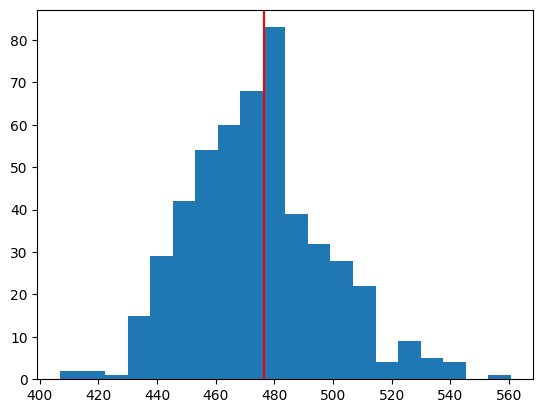

In [8]:
plt.hist(oneway.latest_means, bins=20)
plt.axvline(vanilla.mean(), c='red')

In [70]:
import pandas as pd

dataset_name = "uci_online_retail_ii_customer_order_view"
response_col = "r_BasketValue"
normalize = True

vanilla_path = (
    "_".join([
        "./data/expt_vanilla",
        dataset_name.replace("_", "-"),
        response_col.replace("_", "-"),
        "consolidated.parquet"
    ])
)

bootstrap_path = (
    "_".join([
        "./data/expt_oneway",
        dataset_name.replace("_", "-"),
        response_col.replace("_", "-"),
        "consolidated.parquet"
    ])
)

vanilla_df = pd.read_parquet(vanilla_path)
bootstrap_df = pd.read_parquet(bootstrap_path)

In [73]:
groupby_cols = ["dataset_name", "response_col", "start_time", "end_time", "count"]

combined_experiments_df = (
    vanilla_df.merge(
        bootstrap_df, 
        on=groupby_cols,
        how="inner"
    )
)

plot_statistics_df = (
    combined_experiments_df
    .groupby(groupby_cols)
    .agg(sample_standard_error=pd.NamedAgg(column="sample_standard_error", aggfunc="first"),
         bootstrap_standard_error_mean=pd.NamedAgg(column="bootstrap_standard_error", aggfunc="mean"),
         bootstrap_standard_error_stddev=pd.NamedAgg(column="bootstrap_standard_error", aggfunc="std"),
         bootstrap_standard_error_count=pd.NamedAgg(column="bootstrap_standard_error", aggfunc="count"))
    .reset_index()
    .sort_values('end_time')
)

plot_statistics_df['days_elapsed'] = (plot_statistics_df['end_time'] - plot_statistics_df['start_time']).dt.days
plot_statistics_df['prop_time_elapsed'] = plot_statistics_df['days_elapsed'] / plot_statistics_df['days_elapsed'].iloc[-1]

# Normalize raw standard error by the standard error during first evaluation
if normalize:
    first_day_sample_standard_error = plot_statistics_df['sample_standard_error'][0]
    plot_statistics_df['sample_standard_error'] = (
        plot_statistics_df['sample_standard_error'] / first_day_sample_standard_error
    )
    plot_statistics_df['bootstrap_standard_error_mean'] = (
        plot_statistics_df['bootstrap_standard_error_mean'] / first_day_sample_standard_error
    )
    plot_statistics_df['bootstrap_standard_error_stddev'] = (
        plot_statistics_df['bootstrap_standard_error_stddev'] / first_day_sample_standard_error
    )
    
plot_statistics_df['bootstrap_standard_error_mean_ratio'] = (
    plot_statistics_df['bootstrap_standard_error_mean'] /
    plot_statistics_df['sample_standard_error']
)
  
plot_statistics_df['bootstrap_standard_error_stdev_ratio'] = (
    plot_statistics_df['bootstrap_standard_error_stddev'] /
    plot_statistics_df['sample_standard_error']
)

In [74]:
plot_statistics_df

,dataset_name,response_col,start_time,end_time,count,sample_standard_error,bootstrap_standard_error_mean,bootstrap_standard_error_stddev,bootstrap_standard_error_count,days_elapsed,prop_time_elapsed,bootstrap_standard_error_mean_ratio,bootstrap_standard_error_stdev_ratio
0,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2009-12-15,1075,1.000000,1.399764,0.047816,100,14,0.018397,1.399764,0.047816
1,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2009-12-29,1497,0.808817,1.255193,0.042094,110,28,0.036794,1.551887,0.052044
2,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2010-01-12,1725,1.242258,1.790306,0.057528,98,42,0.055191,1.441170,0.046309
3,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2010-01-26,2213,1.056108,1.771024,0.055001,98,56,0.073587,1.676934,0.052079
4,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2010-02-13,2927,0.851467,1.533745,0.052017,100,74,0.097240,1.801298,0.061091
5,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2010-04-28,6185,0.478740,1.187063,0.037730,99,148,0.194481,2.479559,0.078811
6,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2010-07-11,9643,0.356525,1.014059,0.036838,100,222,0.291721,2.844283,0.103325
7,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2010-09-23,12956,0.305880,1.033720,0.033540,100,296,0.388962,3.379495,0.109652
8,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2010-12-06,18593,0.266346,0.934026,0.029664,99,370,0.486202,3.506810,0.111373
9,uci_online_retail_ii_customer_order_view,r_BasketValue,2009-12-01,2011-02-18,21184,0.294192,0.969746,0.030923,99,444,0.583443,3.296300,0.105111
